In [6]:
import sys
import os

from mmfdl.util.utils_smiecfp import *
from mmfdl.util.data_gen_modify import *
from mmfdl.util.analysis import *
from mmfdl.util.utils import formDataset_Single
from mmfdl.util.normalization import LabelNormalizer

from mmfdl.model.model_combination import *

In [7]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from torch_geometric.loader import DataLoader
from sklearn.linear_model import Lasso
import warnings
from sklearn.linear_model import ElasticNet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import torch
import os
import pandas as pd

In [8]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch_geometric")
warnings.filterwarnings("ignore", message=".*Attempting to run cuBLAS.*", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message=".*weights_only.*")

gpu_index = 1

if torch.cuda.is_available():
    _ = torch.zeros(1).cuda()
device = torch.device(f'cuda:{gpu_index}' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:1


In [9]:
dataset_name = 'Half_Life_Obach'
target_col = 'Half_Life_Obach'

########################
version = 'v1'
norm_mode = 'none'
#########################

start_fold = 1
end_fold = 5
epochs = 50
batch_size = 256
random_state = 42


argsCom = {
    'num_features_smi': 44,
    'num_features_ecfp': 2048,
    'num_features_x': 78,
    'dropout': 0.1, 
    'num_layer': 2,
    'num_heads': 2,
    'hidden_dim': 256,
    'output_dim': 128,
    'n_output': 1
}

print('=' * 60)
print(f'Starting training for {dataset_name} {target_col}')
print(f'Folds: {start_fold} to {end_fold}')
print('=' * 60)

Starting training for Half_Life_Obach Half_Life_Obach
Folds: 1 to 5


Loading datasets for Half_Life_Obach Half_Life_Obach fold 1
Detected max token index: 48. Setting vocab_size to: 49
Detected max sequence length: 44. Setting num_features_smi to: 44
Best model loaded: epoch 50, val_loss: 87.4674
Fold 1 Metrics:
  RMSE: 68.4220
  R2: 0.0046
  PCC: 0.0993
  SRCC: 0.1484


pearson:  PearsonRResult(statistic=np.float64(0.09931473874710435), pvalue=np.float64(0.25538932617277166))
0.002898376371942597 0.09931473874710432
Loading datasets for Half_Life_Obach Half_Life_Obach fold 2
Detected max token index: 48. Setting vocab_size to: 49
Detected max sequence length: 44. Setting num_features_smi to: 44
Best model loaded: epoch 50, val_loss: 134.8435
Fold 2 Metrics:
  RMSE: 137.0391
  R2: -0.0111
  PCC: 0.2597
  SRCC: 0.2908


pearson:  PearsonRResult(statistic=np.float64(0.259708431807913), pvalue=np.float64(0.0025377176904873375))
0.00251138243991959 0.259708431807913
Loading datasets for Half_Life_Obach Half_Life_Obach fold 3
Detected max token index: 48. Se

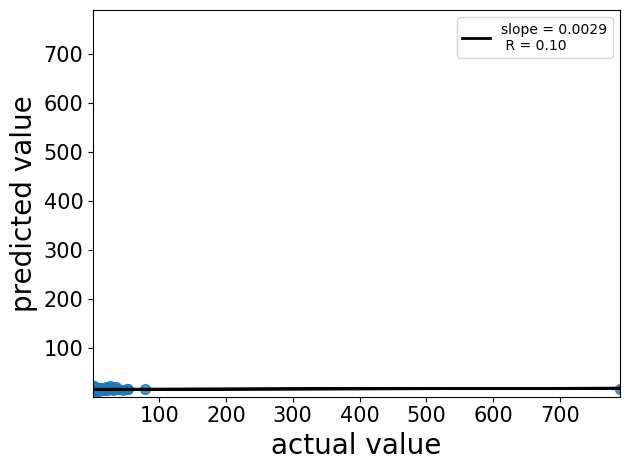

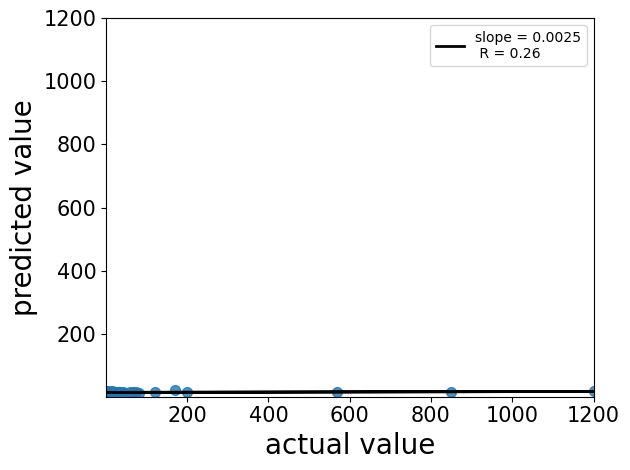

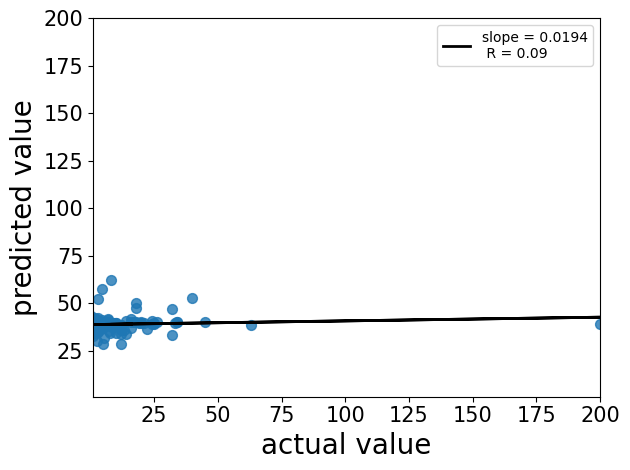

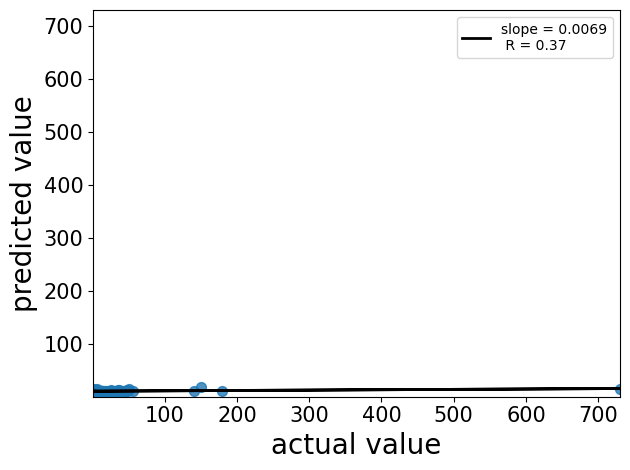

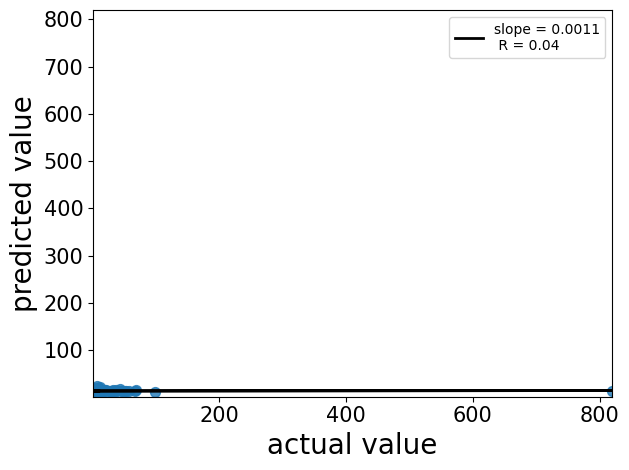

In [10]:
all_fold_metrics = []

for fold_num in range(start_fold, end_fold + 1):
    # print('\n' + '=' * 60)
    # print(f'Processing Fold {fold_num}')
    # print('=' * 60)
    
    # Fold setting
    label = f'{dataset_name}_{target_col}_fold{fold_num}'
    
    resultLoss = {'losses_train': [], 'losses_val': []}
    
    # dataset path
    data_dir = f'./data/{dataset_name}/{target_col}/fold{fold_num}'
    
    # Load dataset
    print(f'Loading datasets for {dataset_name} {target_col} fold {fold_num}')
    train_data = formDataset_Single(root=data_dir, dataset=f'train')
    val_data = formDataset_Single(root=data_dir, dataset=f'val')
    test_data = formDataset_Single(root=data_dir, dataset=f'test')

    max_idx = 0
    max_smi_len = 0
    
    for data in train_data:
        max_idx = max(max_idx, data.smi.max().item())
        max_smi_len = max(max_smi_len, data.smi.shape[1])
    
    if len(val_data) > 0:
        for data in val_data:
            max_idx = max(max_idx, data.smi.max().item())
            max_smi_len = max(max_smi_len, data.smi.shape[1])
            
    if len(test_data) > 0:
        for data in test_data:
            max_idx = max(max_idx, data.smi.max().item())
            max_smi_len = max(max_smi_len, data.smi.shape[1])
    vocab_size = max_idx + 1

    # 중요: vocab_size와 num_features_smi를 각각 설정
    argsCom['vocab_size'] = vocab_size      # 임베딩 레이어용
    argsCom['num_features_smi'] = max_smi_len # Linear 레이어용 (시퀀스 길이)
    
    print(f'Detected max token index: {max_idx}. Setting vocab_size to: {vocab_size}')
    print(f'Detected max sequence length: {max_smi_len}. Setting num_features_smi to: {max_smi_len}')

    # aggregate y labels (only train)
    train_y_labels = []
    for data in train_data:
        train_y_labels.append(data.y.item())
    train_y_labels = np.array(train_y_labels)
    
    # Label Normalizer fit (z-score)
    normalizer = LabelNormalizer(mode=norm_mode)
    normalizer.fit(train_y_labels)
    # print(f'Label Normalizer fitted: mean={normalizer.mean:.4f}, std={normalizer.std:.4f}')
    
    result_dir = os.path.join('results', 'SGD', dataset_name, target_col, version, f'fold{fold_num}')
    os.makedirs(result_dir, exist_ok=True)
    
    # save Normalizer
    normalizer_path = os.path.join(result_dir, 'normalizer.pkl')
    normalizer.save(normalizer_path)
    # print(f'Normalizer saved: {normalizer_path}')
    
    # Generate DataLoader
    trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valLoader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)
    
    # print(f'Train samples: {len(train_data)}')
    # print(f'Validation samples: {len(val_data)}')
    # print(f'Test samples: {len(test_data)}')
    # print('=' * 60)

    best_val_loss = float('inf')
    best_epoch = 0

    learning_rate = 0.0001
    com_model = comModel(argsCom).to(device)
    optimizer_com = torch.optim.Adam(com_model.parameters(), lr=learning_rate)
    criterion_com = torch.nn.MSELoss()

    com_model.train()
    for i in range(epochs):
        # print("Running EPOCH", i+1)
        total_loss = 0
        n_batches = 0
        '''
            train
        '''
        for batch_idx, data in enumerate(trainLoader):
            encodedSmi = torch.LongTensor(data.smi).to(device)
            encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
            ecfp = torch.FloatTensor(data.ep).to(device)
            y = data.y.to(device)
            x = data.x.to(device)
            edge_index = data.edge_index.to(device)
            batch = data.batch.to(device)
            
            # y label normalization
            y_norm = torch.FloatTensor(normalizer.transform(y.cpu().numpy())).to(device)
            
            y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
            
            loss1 = criterion_com(y_pred[0].type(torch.DoubleTensor), y_norm.type(torch.DoubleTensor))
            loss2 = criterion_com(y_pred[1].type(torch.DoubleTensor), y_norm.type(torch.DoubleTensor))
            loss3 = criterion_com(y_pred[2].type(torch.DoubleTensor), y_norm.type(torch.DoubleTensor))
            loss = (loss1 + loss2 + loss3) / 3
            total_loss += (loss.data)/3
            optimizer_com.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(com_model.parameters(),0.5)
            optimizer_com.step()
            n_batches+=1
            torch.cuda.empty_cache()
        avg_loss = total_loss / n_batches
        resultLoss['losses_train'].append(avg_loss)
        # print('train avg_loss is: ', avg_loss.item())

        '''
            val
        '''
        total_loss = 0
        n_batches = 0
        for batch_idx, data in enumerate(valLoader):
            encodedSmi = torch.LongTensor(data.smi).to(device)
            encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
            ecfp = torch.FloatTensor(data.ep).to(device)
            y = data.y.to(device)
            x = data.x.to(device)
            edge_index = data.edge_index.to(device)
            batch = data.batch.to(device)
            
            # y label normalization
            y_norm = torch.FloatTensor(normalizer.transform(y.cpu().numpy())).to(device)
            
            y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
            
            loss1 = criterion_com(y_pred[0].type(torch.DoubleTensor), y_norm.type(torch.DoubleTensor))
            loss2 = criterion_com(y_pred[1].type(torch.DoubleTensor), y_norm.type(torch.DoubleTensor))
            loss3 = criterion_com(y_pred[2].type(torch.DoubleTensor), y_norm.type(torch.DoubleTensor))
            loss = (loss1 + loss2 + loss3) / 3
            
            total_loss += (loss.data)/3
            n_batches+=1
            
        avg_loss = total_loss / n_batches
        resultLoss['losses_val'].append(avg_loss)
        val_loss_value = avg_loss.item()
        # print('val avg_loss is: ', val_loss_value)
        
        # save best model checkpoint
        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            best_epoch = i + 1
            # remove before best checkpoint
            best_checkpoint_path = os.path.join(result_dir, 'best_model.pt')
            if os.path.exists(best_checkpoint_path):
                os.remove(best_checkpoint_path)
            # save new best checkpoint
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': com_model.state_dict(),
                'optimizer_state_dict': optimizer_com.state_dict(),
                'val_loss': best_val_loss,
                'argsCom': argsCom
            }, best_checkpoint_path)
            # print(f'  -> Best model saved! (epoch {best_epoch}, val_loss: {best_val_loss:.4f})')
        # print('\n')

    # load best checkpoint
    best_checkpoint_path = os.path.join(result_dir, 'best_model.pt')
    if os.path.exists(best_checkpoint_path):
        # print(f'Loading best model from checkpoint: {best_checkpoint_path}')
        checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
        com_model.load_state_dict(checkpoint['model_state_dict'])
        # update best epoch
        best_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['val_loss']
        print(f'Best model loaded: epoch {best_epoch}, val_loss: {best_val_loss:.4f}')
    else:
        print(f'Warning: Best checkpoint not found, using last epoch model')
    
    val_data = []
    pred_data1 = []
    pred_data2 = []
    pred_data3 = []
    com_model.eval()
    for batch_idx, data in enumerate(valLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = data.y.to(device)
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        
        # y label normalization
        y_norm = torch.FloatTensor(normalizer.transform(y.cpu().numpy())).to(device)
        
        y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
        val_data.append(y_norm.cpu().tolist())
        pred_data1.append(y_pred[0].tolist())
        pred_data2.append(y_pred[1].tolist())
        pred_data3.append(y_pred[2].tolist()) 

    def flattened_data(data):
        fla_data = [item for sublist in data for item in sublist]
        merged_data = np.array(fla_data).flatten() 
        return merged_data

    data_ = {}
    data_['pred1'] = flattened_data(pred_data1)
    data_['pred2'] = flattened_data(pred_data2)
    data_['pred3'] = flattened_data(pred_data3)
    data_['true'] = flattened_data(val_data)

    val_data_flat = flattened_data(val_data).astype(np.float32)
    pred_data1_flat = flattened_data(pred_data1).astype(np.float32)
    pred_data2_flat = flattened_data(pred_data2).astype(np.float32)
    pred_data3_flat = flattened_data(pred_data3).astype(np.float32)

    learning_rate_weight = 0.01
    weights = torch.tensor([0.7, 0.2, 0.1], requires_grad=True, dtype=torch.float)
    optimizer_weight = torch.optim.SGD([weights], lr=learning_rate_weight)
    criterion_weight = torch.nn.MSELoss()

    val_data_tensor = torch.from_numpy(val_data_flat)
    pred_data1_tensor = torch.from_numpy(pred_data1_flat)
    pred_data2_tensor = torch.from_numpy(pred_data2_flat)
    pred_data3_tensor = torch.from_numpy(pred_data3_flat)
    for i in range(epochs):
        # print("Running EPOCH", i+1)
        if weights.data.sum() > 1:
            weights.data /= weights.data.sum()
        # Compute weighted_output using torch operations, not .detach().numpy()
        weighted_output = (weights[0] * pred_data1_tensor + weights[1] * pred_data2_tensor + weights[2] * pred_data3_tensor).to(device)
        val_output = val_data_tensor.to(device)
        loss = criterion_weight(weighted_output, val_output)
        optimizer_weight.zero_grad()
        loss.backward()
        optimizer_weight.step()
        # print('weight loss is: ', loss.item())
    # print('\n')

    numpy_weights = weights.detach().numpy()
    weightDic = {}
    weightDic[1] = numpy_weights[0]
    weightDic[2] = numpy_weights[1]
    weightDic[3] = numpy_weights[2]
    # print(weightDic)

    def calRmseMae(y, y_pred):
        yResult = {}
        ground_truth = y
        predictions = y_pred
        # calculate rmse
        squared_errors = (ground_truth - predictions) ** 2
        rmse = np.sqrt(np.mean(squared_errors))
        yResult['rmse'] = rmse
        # calculate mae
        absolute_errors = np.abs(ground_truth - predictions)
        mae = np.mean(absolute_errors)
        yResult['mae'] = mae
        return yResult

    sour_data = []
    pred_data1 = []
    pred_data2 = []
    pred_data3 = []

    com_model.eval()
    for batch_idx, data in enumerate(testLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = data.y.to(device)
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        
        # y label normalization
        y_norm = torch.FloatTensor(normalizer.transform(y.cpu().numpy())).to(device)
        
        y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
        sour_data.append(y_norm.cpu().tolist())
        pred_data1.append(y_pred[0].tolist())
        pred_data2.append(y_pred[1].tolist())
        pred_data3.append(y_pred[2].tolist()) 
    yPred = numpy_weights[0] * flattened_data(pred_data1) + numpy_weights[1] * flattened_data(pred_data2) + numpy_weights[2] * flattened_data(pred_data3)
    ySour = flattened_data(sour_data)
    
    if len(yPred) == 0 or len(ySour) == 0:
        # print(f'Warning: Empty predictions or targets. yPred length={len(yPred)}, ySour length={len(ySour)}')
        # print(f'Skipping result saving for fold {fold_num}')
        continue
    
    if len(yPred) != len(ySour):
        # print(f'Warning: Length mismatch. yPred length={len(yPred)}, ySour length={len(ySour)}. Truncating to min length.')
        min_len = min(len(yPred), len(ySour))
        yPred = yPred[:min_len]
        ySour = ySour[:min_len]

    rmse = np.sqrt(mean_squared_error(ySour, yPred))
    r2 = r2_score(ySour, yPred)
    pcc = pearsonr(ySour, yPred)[0]
    srcc = spearmanr(ySour, yPred)[0]

    fold_metrics = {
        'fold': fold_num,
        'rmse': rmse,
        'r2': r2,
        'pcc': pcc,
        'srcc': srcc
    }
    all_fold_metrics.append(fold_metrics)
    
    print(f'Fold {fold_num} Metrics:')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  R2: {r2:.4f}')
    print(f'  PCC: {pcc:.4f}')
    print(f'  SRCC: {srcc:.4f}')
    
    print('\n')
    
    # 1. save weight (best model)
    savePath = f'{result_dir}/{label}_weight_epoch_{best_epoch}.csv'
    df_weight = pd.DataFrame(weightDic.items(), columns=['Key', 'Value'])
    df_weight.to_csv(savePath, index=False)
    # print(f'Weight saved: {savePath}')
    
    # 2. save predictions.csv on each fold
    predictions_df = pd.DataFrame({
        'y_true': ySour,
        'y_pred': yPred
    })
    predictions_path = f'{result_dir}/predictions.csv'
    predictions_df.to_csv(predictions_path, index=False)
    # print(f'Predictions saved: {predictions_path}')
    
    # 3. save metric.csv on each fold
    metric_df = pd.DataFrame([fold_metrics])
    metric_path = f'{result_dir}/metric.csv'
    metric_df.to_csv(metric_path, index=False)
    # print(f'Metrics saved: {metric_path}')
    
    # 4. save scatter plot (best model)
    savePath = f'{result_dir}/{label}_scatter_predited_epoch_{best_epoch}_com.png'
    pltPredict_linregress(yPred, ySour, savePath)
    
    # 5. save validation data (best model)
    savePath = f'{result_dir}/{label}_validation_epoch_{best_epoch}_data.csv'
    data_as_lists = {key: data_[key].tolist() for key in data_}
    df_data = pd.DataFrame(data_as_lists)
    df_data.to_csv(savePath, index=False)
    # print(f'Validation data saved: {savePath}')
    
    # print(f'\nFold {fold_num} completed!')
    # print(f'Best model: epoch {best_epoch}, val_loss: {best_val_loss:.4f}')
    # print(f'Checkpoint saved at: {result_dir}')
    # print('=' * 60)

print('\n' + '=' * 60)
print('All folds completed!')
print('=' * 60)


if len(all_fold_metrics) > 0:
    all_metrics_df = pd.DataFrame(all_fold_metrics)
    
    # compute mean, std
    summary_metrics = {
        'metric': ['rmse', 'r2', 'pcc', 'srcc'],
        'mean': [
            all_metrics_df['rmse'].mean(),
            all_metrics_df['r2'].mean(),
            all_metrics_df['pcc'].mean(),
            all_metrics_df['srcc'].mean()
        ],
        'std': [
            all_metrics_df['rmse'].std(),
            all_metrics_df['r2'].std(),
            all_metrics_df['pcc'].std(),
            all_metrics_df['srcc'].std()
        ]
    }
    summary_df = pd.DataFrame(summary_metrics)

    summary_dir = f'./results/SGD/{dataset_name}/{target_col}/{version}'
    os.makedirs(summary_dir, exist_ok=True)
    summary_path = f'{summary_dir}/summary_metric.csv'
    summary_df.to_csv(summary_path, index=False)
    # print(f'\nSummary metrics saved: {summary_path}')
    # print('\nSummary Metrics (Test Set):')
    # print(summary_df.to_string(index=False))

    all_metrics_path = f'{summary_dir}/all_folds_metrics.csv'
    all_metrics_df.to_csv(all_metrics_path, index=False)
    # print(f'All folds metrics saved: {all_metrics_path}')